In [2]:
import struct
import numpy as np
import matplotlib.pyplot as plt

def tlvHeaderDecode(data):
    (tlvType, tlvLength) = struct.unpack('2I', data)
    return (tlvType, tlvLength)

def parseDetectedObjects(data, tlvLength, numDetectedObj):  
    if tlvLength != numDetectedObj * 16:
        raise ValueError(f"tlvLength ({tlvLength}) is not congruent with the number of detected objects ({numDetectedObj}).")
    
    object_coordinates = []
    for i in range(numDetectedObj):
        offset = 16*i
        print(data[offset:offset+16])
        x, y, z, v = struct.unpack('4f', data[offset:offset+16])
        print(x, y, z, v)
        object_coordinates.append((x, y, z, v))
    
    return object_coordinates

def parseStats(data, tlvLength):
    (
        interProcess,
        transmitOut,
        frameMargin,
        chirpMargin,
        activeCPULoad,
        interCPULoad,
        ) = struct.unpack('6I', data[:24])
    return {
        'ChirpMargin': chirpMargin,
        'FrameMargin': frameMargin,
        'InterCPULoad': interCPULoad,
        'ActiveCPULoad': activeCPULoad,
        'TransmitOut': transmitOut,
        'Interprocess': interProcess
    }

def parseRangeProfile(data, tlvLength):
    range_profile = []
    for i in range(tlvLength // 2):  # Dividing by 2 to get the number of uint16_t values in the data
        profile_value_int = struct.unpack('H', data[2*i:2*i+2])[0]
        profile_value_float = profile_value_int / (1 << 9)  # Convert from Q9 format to float
        range_profile.append(profile_value_float)
    return range_profile

def parsePacket(data):
    packet_info = {}

    headerLength = 36
    (
        magic,
        version,
        length,
        platform,
        frameNum,
        cpuCycles,
        numObj,
        numTLVs,
    ) = struct.unpack('Q7I', data[:headerLength])

    packet_info['Frame_Number'] = frameNum
    packet_info['Version'] = f"{version:08x}"  # Format version as an 8-digit hexadecimal string
    packet_info['TLV_count'] = numTLVs
    packet_info['Detected_Objects'] = numObj
    packet_info['Platform'] = f"{platform:08x}"

    if version > 0x01000005:
        subFrameNum = struct.unpack('I', data[36:40])[0]
        headerLength = 40
        packet_info['Subframe'] = subFrameNum

    data = data[headerLength:]
    pendingBytes = length - headerLength

    tlv_data = {}
    for i in range(numTLVs):
        (tlvType, tlvLength) = tlvHeaderDecode(data[:8])
        data = data[8:]

        if tlvType == 1:
            object_coordinates = parseDetectedObjects(data, tlvLength, numObj)
            tlv_data['Detected_Object_Coordinates'] = object_coordinates
        elif tlvType == 2:
            range_profile = parseRangeProfile(data, tlvLength)
            tlv_data['Range_Profile'] = range_profile
        elif tlvType == 6:
            stats = parseStats(data, tlvLength)
            tlv_data['Stats'] = stats
        else:
            tlv_data['Unidentified_TLV_Type'] = tlvType

        data = data[tlvLength:]
        pendingBytes -= 8 + tlvLength

    packet_info['TLV_Data'] = tlv_data

    return packet_info  # Return the single packet dictionary


def splitPacketsByMagic(rawData, magic=b'\x02\x01\x04\x03\x06\x05\x08\x07'):
    # Find all occurrences of the magic sequence
    packet_starts = [i for i in range(len(rawData) - len(magic) + 1) if rawData[i:i+len(magic)] == magic]

    # Split the rawData into packets using the found indices
    packets = []
    for start, end in zip(packet_starts, packet_starts[1:] + [None]):
        packets.append(rawData[start:end])
        
    return packets

def plot_points_3D(points, frame_number):
    if not points:
        print("No detected object coordinates found.")
        return

    x_vals, y_vals, z_vals, _ = zip(*points)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_vals, y_vals, z_vals)

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    plt.title(f"Frame_Number: {frame_number}")

    plt.show()


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor

def plot_points_2D(points, frame_number):
    if not points:
        print("No detected object coordinates found.")
        return

    x_vals, y_vals, _, _ = zip(*points)
    
    # Convert x_vals and y_vals to numpy arrays for further processing
    x = np.array(x_vals).reshape(-1, 1)
    y = np.array(y_vals)
    
    # RANSAC line fitting
    ransac = make_pipeline(PolynomialFeatures(1), RANSACRegressor(random_state=42))
    ransac.fit(x, y)
    line_x = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    line_y = ransac.predict(line_x)
    
    # Calculate the slope of the line
    coef = ransac.steps[-1][1].estimator_.coef_[1]
    
    # Calculate the angle in degrees
    angle = np.arctan(coef) * (180.0 / np.pi)

    plt.scatter(x_vals, y_vals, label='Detected Points')
    plt.plot(line_x, line_y, color='red', label='RANSAC line fit')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f"Frame_Number: {frame_number}\nAngle with horizontal: {angle:.2f} degrees")
    plt.legend()
    plt.grid(True)
    plt.show()

    return angle

def extract_points_from_frame(packet):
    """Extracts and returns the list of points from a given frame."""
    return packet.get('TLV_Data', {}).get('Detected_Object_Coordinates', [])

def calculate_mean_excluding_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    return np.mean(filtered_data) if filtered_data else None






In [3]:
#what these actuially mean
presets = [0, 7.8, 9.2, 10.8, 12.4] #0-4

# List of file paths and their numbers
# file_paths = [
#     ("D:/REPOS/mmw/slope-diff-data/1/xwr16xx_processed_stream_2023_09_14T16_41_41_550.dat", 1),
#     ("D:/REPOS/mmw/slope-diff-data/2/xwr16xx_processed_stream_2023_09_14T16_45_47_921.dat", 2),
#     ("D:/REPOS/mmw/slope-diff-data/3/xwr16xx_processed_stream_2023_09_14T16_50_28_987.dat", 3)
# ]

file_paths = [
    ("D:/REPOS/mmw/slope-diff-data/1/xwr16xx_processed_stream_2023_09_14T16_41_23_134.dat", 1),
    ("D:/REPOS/mmw/slope-diff-data/2/xwr16xx_processed_stream_2023_09_14T16_45_33_820.dat", 2),
    ("D:/REPOS/mmw/slope-diff-data/3/xwr16xx_processed_stream_2023_09_14T16_50_15_005.dat", 3)
]

all_parsed_data = {}

for file_path, file_num in file_paths:
    with open(file_path, "rb") as rawDataFile:
        rawData = rawDataFile.read()

    packets = splitPacketsByMagic(rawData)

    parsed_data_for_file = [parsePacket(packet) for packet in packets]
    all_parsed_data[file_num] = (parsed_data_for_file)

print(all_parsed_data)

b'_\x1e-\xbd-M1<\x00\x00\x00\x00\x00\x00\x00\x00'
-0.04226529225707054 0.010821622796356678 0.0 0.0
b'\xff`_\xbc\xd5\xc0)=\x00\x00\x00\x00\x00\x00\x00\x00'
-0.013633965514600277 0.04144366458058357 0.0 0.0
b"\xd5\xe2\x02\xbf\xe0'\xd1>\x00\x00\x00\x00\x00\x00\x00\x00"
-0.5112736821174622 0.4085073471069336 0.0 0.0
b'>\x8cj\xbe\x8f\x97\x99?\x00\x00\x00\x00\x00\x00\x00\x00'
-0.22905060648918152 1.1999377012252808 0.0 0.0
b'K\x01\xb2>\xac\xa7\x0c@\x00\x00\x00\x00\x00\x00\x00\x00'
0.3476661145687103 2.1977338790893555 0.0 0.0
b'\xdf!\xf0>\xb7?n@\x00\x00\x00\x00\x00\x00\x00\x00'
0.4690084159374237 3.7226388454437256 0.0 0.0
b'\xc6\x0e(\xc0\x89\x05w@\x00\x00\x00\x00\x00\x00\x00\x00'
-2.625901699066162 3.859712839126587 0.0 0.0
b'\xa7D\xbf>\xed\xe4\xbe@\x00\x00\x00\x00\x00\x00\x00\x00'
0.37357065081596375 5.965445041656494 0.0 0.0
b'_\x1e-\xbd-M1<\x00\x00\x00\x00\x00\x00\x00\x00'
-0.04226529225707054 0.010821622796356678 0.0 0.0
b'\xff`_\xbc\xd5\xc0)=\x00\x00\x00\x00\x00\x00\x00\x00'
-0.013633

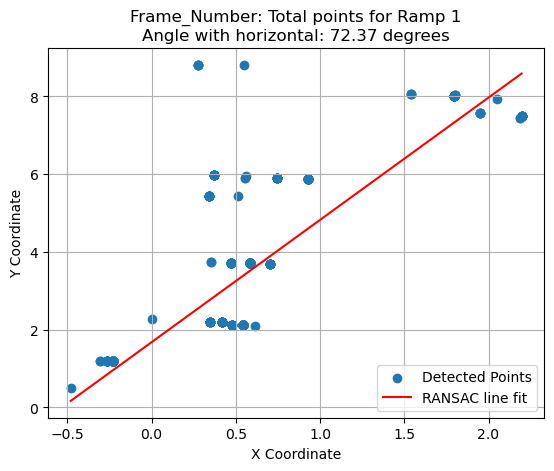

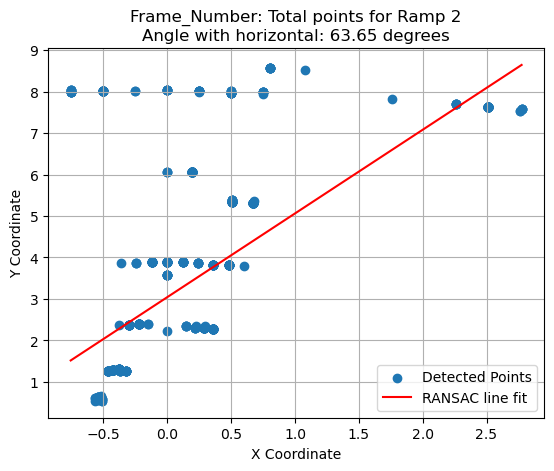

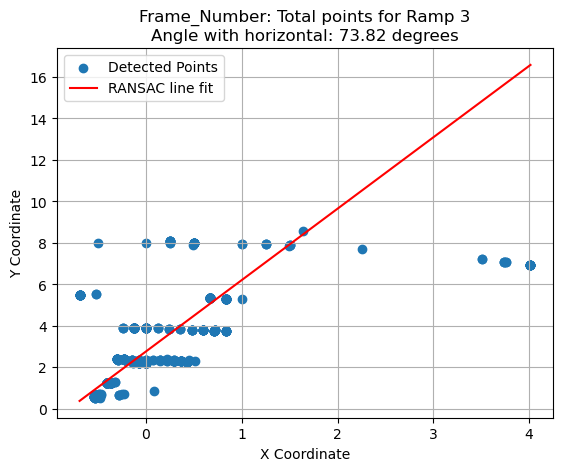

In [4]:
for ramp_number in all_parsed_data.keys():
    all_points = []
    for frame in all_parsed_data[ramp_number]:
        points = extract_points_from_frame(frame)
        # Filter points with y value less than 0.5 and x value greater than -1
        filtered_points = [(x, y, z, v) for (x, y, z, v) in points if y >= 0.5 and x > -1]
        all_points.extend(filtered_points)
    
    plot_points_2D(all_points, f"Total points for Ramp {ramp_number}")


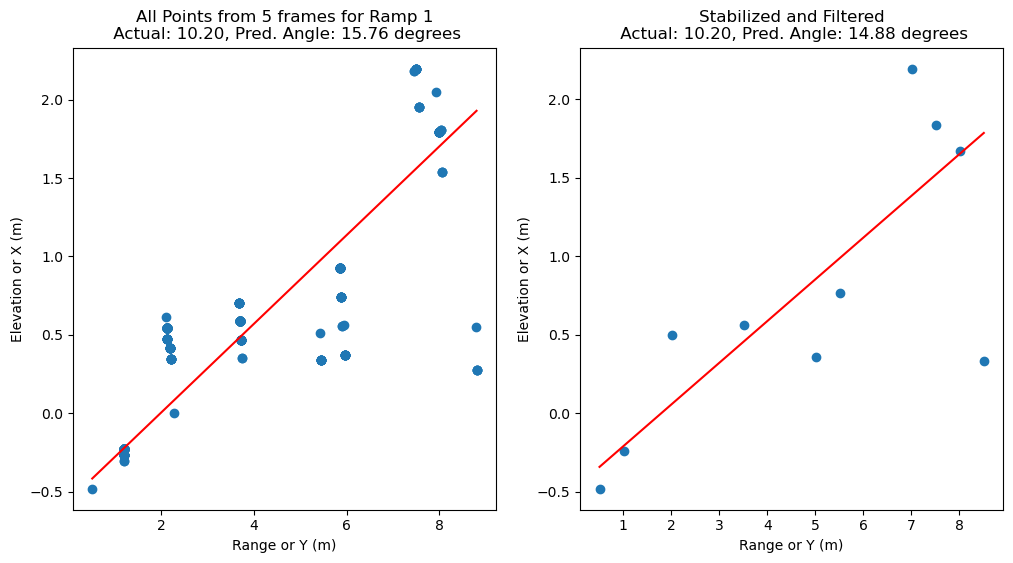

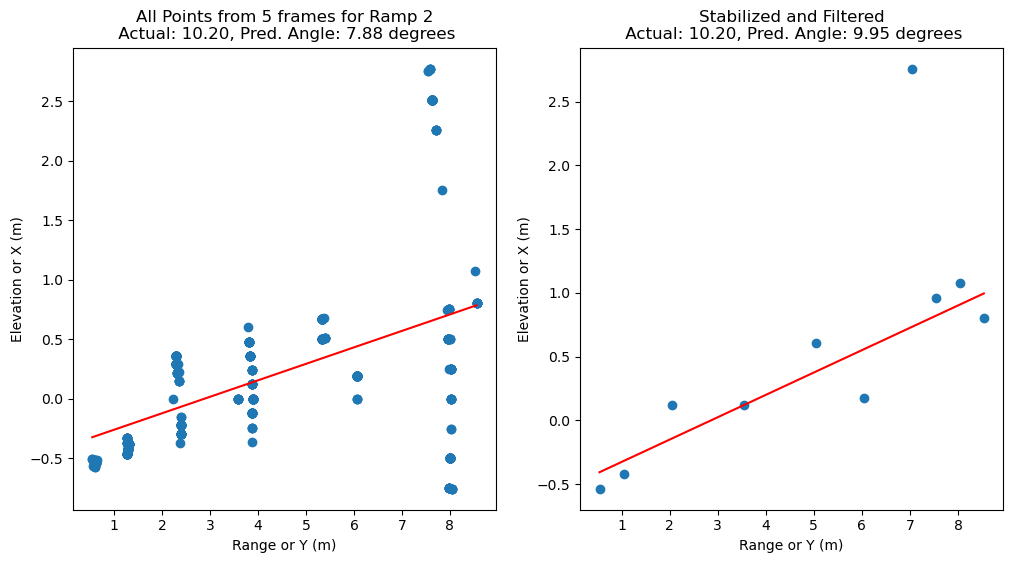

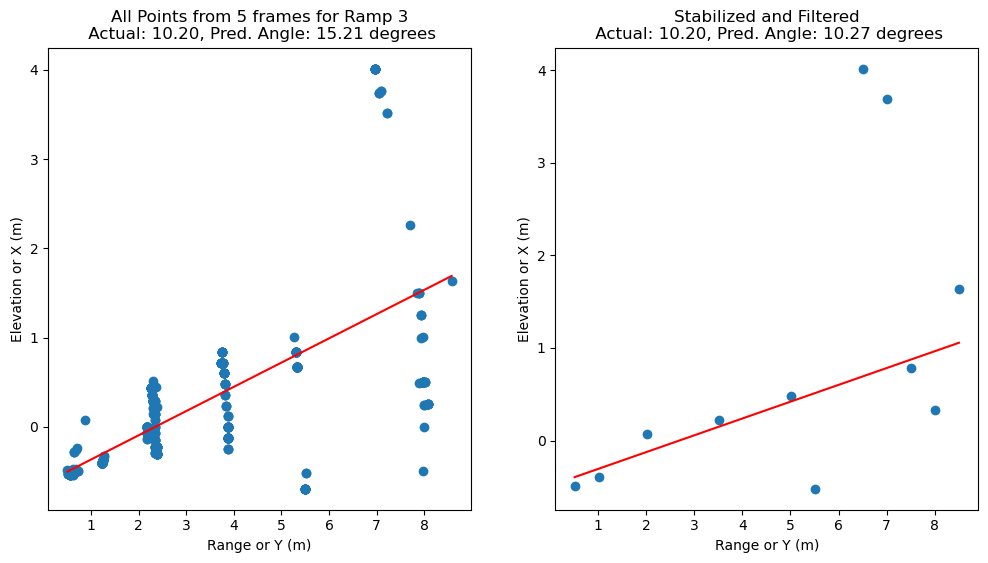

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def average_x_per_y_group(points, bin_width):
    y_min = min(y for _, y, _, _ in points)
    y_max = max(y for _, y, _, _ in points)
    bins = np.arange(y_min, y_max + bin_width, bin_width)
    grouped_points = {bin_val: [] for bin_val in bins}

    for x, y, _, _ in points:
        bin_index = int((y - y_min) / bin_width)
        grouped_points[bins[bin_index]].append(x)

    avg_x_per_group = []
    for bin_val, x_values in grouped_points.items():
        if x_values:
            avg_x = sum(x_values) / len(x_values)
            avg_x_per_group.append((avg_x, bin_val))

    return avg_x_per_group

def plot_points_2D(points, title, ax):
    x_vals, y_vals, _, _ = zip(*points)
    x = np.array(x_vals).reshape(-1, 1)
    y = np.array(y_vals)

    # RANSAC line fitting
    ransac = RANSACRegressor(random_state=42)
    ransac.fit(y.reshape(-1, 1), x)
    line_y = np.linspace(y.min(), y.max(), 100).reshape(-1, 1)
    line_x = ransac.predict(line_y)

    # Calculate the slope of the line
    coef = ransac.estimator_.coef_[0] if isinstance(ransac.estimator_.coef_, np.ndarray) else ransac.estimator_.coef_
    coef = coef.item() if isinstance(coef, np.ndarray) else coef  # Ensure coef is a scalar

    # Calculate the angle in degrees
    angle = np.arctan(1 / coef) * (180.0 / np.pi)

    ax.scatter(y_vals, x_vals)
    ax.plot(line_y.ravel(), line_x, color='red')
    ax.set_xlabel('Range or Y (m)')
    ax.set_ylabel('Elevation or X (m)')
    ax.set_title(f"{title}\n Actual: {10.2:.2f}, Pred. Angle: {90 - angle:.2f} degrees")

def plot_averaged_points_with_line(averaged_points, title, ax):
    if not averaged_points:
        ax.text(0.5, 0.5, 'No data to display', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        return

    x_vals, y_vals = zip(*averaged_points)
    x = np.array(x_vals).reshape(-1, 1)
    y = np.array(y_vals)


    # RANSAC line fitting
    ransac = RANSACRegressor(random_state=42)
    ransac.fit(y.reshape(-1, 1), x)
    line_y = np.linspace(y.min(), y.max(), 100).reshape(-1, 1)
    line_x = ransac.predict(line_y)

    # Calculate the slope of the line
    coef = ransac.estimator_.coef_[0] if isinstance(ransac.estimator_.coef_, np.ndarray) else ransac.estimator_.coef_
    coef = coef.item() if isinstance(coef, np.ndarray) else coef  # Ensure coef is a scalar

    # Calculate the angle in degrees
    angle = np.arctan(1 / coef) * (180.0 / np.pi)

    ax.scatter(y_vals, x_vals)
    ax.plot(line_y.ravel(), line_x, color='red')
    ax.set_xlabel('Range or Y (m)')
    ax.set_ylabel('Elevation or X (m)')
    ax.set_title(f"{title}\n Actual: {10.2:.2f}, Pred. Angle: {90 - angle:.2f} degrees")

# Example usage
bin_width = 0.5  # Adjust this as needed
for ramp_number in all_parsed_data.keys():
    all_points = []
    for frame in all_parsed_data[ramp_number]:
        points = extract_points_from_frame(frame)
        filtered_points = [(x, y, z, v) for (x, y, z, v) in points if y >= 0.5 and x > -1]
        all_points.extend(filtered_points)

    averaged_points = average_x_per_y_group(all_points, bin_width)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_points_2D(all_points, f"All Points from 5 frames for Ramp {ramp_number}", axs[0])
    plot_averaged_points_with_line(averaged_points, f"Stabilized and Filtered", axs[1])
    plt.show()


In [34]:
results = []

# for file_path, file_num in file_paths:
#     with open(file_path, "rb") as rawDataFile:
#         rawData = rawDataFile.read()

#     packets = splitPacketsByMagic(rawData)

#     parsed_data = [parsePacket(packet) for packet in packets]

#     angles = [plotPacketPoints2D(each) for each in parsed_data if plotPacketPoints2D(each) is not None]

#     avg_angle = calculate_mean_excluding_outliers(angles)
#     results.append((file_path, file_num, avg_angle))

# Save results to a text file
with open("output_results.txt", "w") as f:
    for file_path, file_num, avg_angle in results:
        f.write(f"File {file_num} ({file_path}): Average Angle = {avg_angle:.2f}\n")
